In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
EPOCHS = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 32
SEED = 42
TRAIN_VAL_TEST_SPLIT = [0.7, 0.2, 0.1]

N_FEATURES = 5
HIDDEN_SIZE = 128
N_LAYERS = 2
N_OUTPUTS = 1

## Data Preprocessing

In [3]:
df = pd.read_csv("./data/tesla-stock-price.csv")
df.head()

,date,close,volume,open,high,low
0,11:34,270.49,"4,787,699",264.50,273.88,262.2400
1,2018/10/15,259.59,6189026.0000,259.06,263.28,254.5367
2,2018/10/12,258.78,7189257.0000,261.00,261.99,252.0100
3,2018/10/11,252.23,8128184.0000,257.53,262.25,249.0300
4,2018/10/10,256.88,12781560.0000,264.61,265.51,247.7700


In [4]:
if 'date' in df.columns:
    df.drop(["date"], axis=1, inplace=True)
target_idx = df.columns.get_loc("close")
print(f'Target index: {target_idx}')

for col in df.columns:
    df[col] = df[col].replace(",", "", regex=True).astype(float)

mean = df.mean()
std = df.std()

# normalize data
df = df.astype(float)
df = (df - mean) / std
df.head()

Target index: 0


,close,volume,open,high,low
0,-0.036925,-0.353463,-0.141329,-0.054781,-0.100449
1,-0.223637,0.010910,-0.234400,-0.233851,-0.234383
2,-0.237512,0.270990,-0.201209,-0.255644,-0.278313
3,-0.349711,0.515130,-0.260577,-0.251252,-0.330125
4,-0.270058,1.725101,-0.139447,-0.196179,-0.352032


In [5]:
def sliding_window(data, window_size, window_step):
    """Sliding window over a sequence of data.

    Args:
        data (list or dataframe): Data to be sliced.
        window_size (int): Size of the window.
        window_step (int): Step size of the window.
    """
    n = len(data)
    result = []
    for i in range(0, n - window_size + 1, window_step):
        result.append(np.array(data[i : i + window_size]))
    return result

data = sliding_window(df, 11, 1)

In [6]:
data = np.array(data)
data.shape

(747, 11, 5)

In [7]:
print(f'Data[0].shape: {data[0].shape}')
print(data[0])

Data[0].shape: (11, 5)
[[-0.03692474 -0.35346272 -0.14132905 -0.05478147 -0.10044902]
 [-0.22363705  0.01091026 -0.23440033 -0.23385137 -0.2343828 ]
 [-0.237512    0.27099029 -0.20120947 -0.25564384 -0.27831339]
 [-0.34971067  0.51513005 -0.26057662 -0.25125156 -0.33012529]
 [-0.27005818  1.72510068 -0.1394471  -0.19617912 -0.35203234]
 [-0.16865113  1.53170304 -0.29958444 -0.17489345 -0.25588474]
 [-0.37831705  1.87841365 -0.14098688 -0.15817069 -0.33064689]
 [-0.18321126  3.05618185  0.03232416 -0.03788808 -0.13939488]
 [ 0.15732457  0.90794246  0.36252188  0.28511348  0.16782539]
 [ 0.37949508  0.47719001  0.5230014   0.46418338  0.40949838]
 [ 0.486041    1.44379289  0.70469569  0.67095844  0.5412884 ]]


In [8]:
class TelsaStockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

## Model

In [9]:
class ForecastModel(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers=2, batch_first=True):
        super(ForecastModel, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.batch_first = batch_first

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.5,
            batch_first=batch_first,
        )
        self.fc1 = nn.Linear(in_features=n_hidden, out_features=n_hidden // 2)
        self.batchnorm = nn.BatchNorm1d(n_hidden // 2)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(in_features=n_hidden // 2, out_features=1)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        if self.batch_first:
            lstm_out = lstm_out[:, -1, :]
        else:
            lstm_out = lstm_out[-1, :, :]
        lstm_out = lstm_out.view(-1, self.n_hidden).contiguous()
        out = self.fc1(lstm_out)
        out = self.batchnorm(out)
        out = self.activation(out)
        out = self.fc2(out)
        return out

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = self.forward(x)
        return x

In [10]:
model = ForecastModel(n_features=5, n_hidden=128, n_layers=2, batch_first=True)
model

ForecastModel(
  (lstm): LSTM(5, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

## Training

In [11]:
def train_fn(model, dataloader, optimizer, criterion, device):
    model.train()
    model = model.to(device)
    losses = []
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    return sum(losses) / len(losses)

def eval_fn(model, dataloader, criterion, device):
    model.eval()
    model = model.to(device)
    losses = []
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        
        losses.append(loss.item())
    
    return sum(losses) / len(losses)


In [12]:
# use target_idx to get the target column
X = data[:, :-1, :]
y = data[:, -1, target_idx:target_idx+1]
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

# train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TRAIN_VAL_TEST_SPLIT[2], random_state=SEED) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TRAIN_VAL_TEST_SPLIT[1]/(TRAIN_VAL_TEST_SPLIT[0]+TRAIN_VAL_TEST_SPLIT[1]), random_state=SEED)
print(f'X_train.shape: {X_train.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'X_test.shape: {X_test.shape}')

X.shape: (747, 10, 5)
y.shape: (747, 1)
X_train.shape: (522, 10, 5)
X_val.shape: (150, 10, 5)
X_test.shape: (75, 10, 5)


In [13]:
train_dataset = TelsaStockDataset(X_train, y_train)
val_dataset = TelsaStockDataset(X_val, y_val)
test_dataset = TelsaStockDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ForecastModel(n_features=N_FEATURES, n_hidden=HIDDEN_SIZE, n_layers=N_LAYERS, batch_first=True)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss(reduction='sum')

In [15]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_dataloader, optimizer, criterion, device)
    val_loss = eval_fn(model, val_dataloader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch: 1/50, Train Loss: 4.8951, Val Loss: 24.3051
Epoch: 2/50, Train Loss: 2.2225, Val Loss: 14.6942
Epoch: 3/50, Train Loss: 2.0849, Val Loss: 5.8048
Epoch: 4/50, Train Loss: 1.8985, Val Loss: 1.8471
Epoch: 5/50, Train Loss: 2.2054, Val Loss: 0.9837
Epoch: 6/50, Train Loss: 1.7091, Val Loss: 0.7258
Epoch: 7/50, Train Loss: 2.2072, Val Loss: 0.8487
Epoch: 8/50, Train Loss: 2.2577, Val Loss: 1.1475
Epoch: 9/50, Train Loss: 2.0166, Val Loss: 1.0225
Epoch: 10/50, Train Loss: 1.5151, Val Loss: 0.6617
Epoch: 11/50, Train Loss: 1.8367, Val Loss: 0.6634
Epoch: 12/50, Train Loss: 1.4895, Val Loss: 0.7837
Epoch: 13/50, Train Loss: 1.2224, Val Loss: 0.6684
Epoch: 14/50, Train Loss: 1.6774, Val Loss: 0.6090
Epoch: 15/50, Train Loss: 1.6569, Val Loss: 0.7129
Epoch: 16/50, Train Loss: 1.6021, Val Loss: 0.6957
Epoch: 17/50, Train Loss: 1.6202, Val Loss: 0.7293
Epoch: 18/50, Train Loss: 1.8108, Val Loss: 0.5860
Epoch: 19/50, Train Loss: 1.1705, Val Loss: 0.5906
Epoch: 20/50, Train Loss: 1.0131, Val 

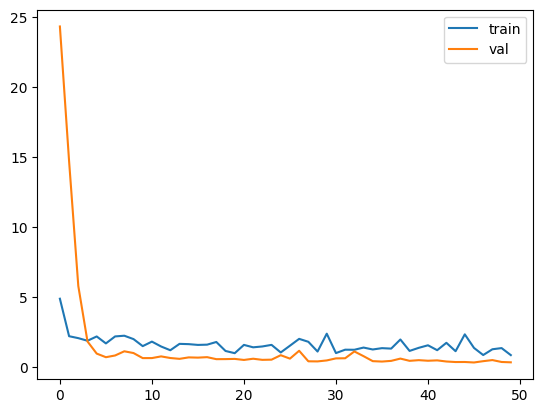

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

## Test

In [17]:
test_loss = eval_fn(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.1506


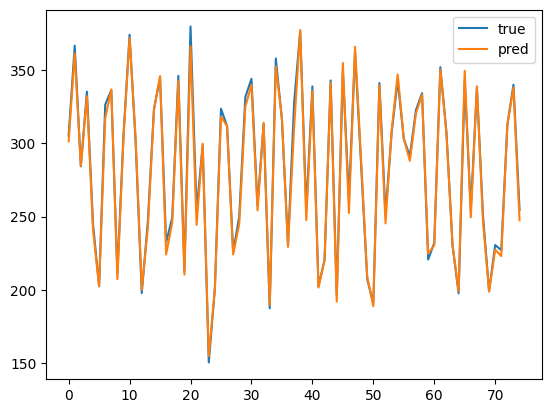

In [18]:
# plot the test true value and predicted value
model = model.to(device)
model.eval()
with torch.no_grad():
    y_pred = model.predict(torch.from_numpy(X_test).float().to(device))
y_pred = y_pred.cpu().numpy()
y_pred = y_pred * std[target_idx] + mean[target_idx]
y_test = y_test * std[target_idx] + mean[target_idx]

plt.plot(y_test, label='true')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()
